In [2]:
# Import needed packages
import time
import itertools
import numpy as np
import pandas as pd
import scipy
import random
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

What does a graph have?
- list of edges (tuple, in order of addition)
- node neighborlist (defaultdic)

In [49]:
def check_if_edge_exists(proposed,edges):
    for item in edges:
        if proposed==item: return True
        else: pass

def edges_to_viz(edges,n):
        viz_array = np.zeros((n,n))
        for i in edges:
            viz_array[i[0],i[1]]+=1
        return viz_array

def edges_to_children(edges):
    children = defaultdict(list)
    for u,v in edges:
        children[u].append(v)
    return children
    
def tarjan(neighbors):  
        index_counter = [0]
        index = {}
        lowlink = {}
        stack = []

        result = []

        # v is node-- wait, but shouldn't it actually be u...?
        def calc_component(node):
            # v.index, v.lowlink
            index[node] = index_counter[0]
            lowlink[node] = index_counter[0]
            index_counter[0] += 1
            stack.append(node)

            # find the children
            try:
                children = neighbors[node]
            except:
                children = []
            for child in children:
                # if the child hasn't been visited, run this on it
                if child not in lowlink:
                    calc_component(child)
                    lowlink[node] = min(lowlink[node],lowlink[child])
                # if the child is in the stack, that means they're also in the SCC
                elif child in stack:
                    lowlink[node] = min(lowlink[node],index[child])

            if lowlink[node]==index[node]:
                connected_component = []
                while True:
                    successor = stack.pop()
                    connected_component.append(successor)
                    if successor == node: break
                component = tuple(connected_component)
                # storing the result
                result.append(component)
    #     print(neighbors)
        for node in list(neighbors):
            if node not in lowlink:
                calc_component(node)

        return result

In [43]:
class Graph(object):
  
    def __init__(self,n,m,process_name):
        self.n = n
        self.m = m
        self.edge_density = m/n
        self.edges = []
        self.LJ = 0
        
        self.process = process_name 
        
    def initialize(self):
        if self.process=='CODER': self.CODER()
        elif self.process=="ODER": self.ODER()
        else: print('initialize with a valid process')
    
    def add_edge(self,proposed_edge):
        if check_if_edge_exists(proposed_edge,self.edges):
            if check_if_edge_exists(tuple(reversed(proposed_edge)),self.edges): pass
            else: self.edges.append(tuple(reversed(proposed_edge)))
        else: self.edges.append(proposed_edge)

    def ODER(self):
        # set up list nodes with ranked order
        n_list = np.linspace(0,self.n-1,self.n).astype(int)
        # add m edges to the plot
        while len(self.edges)<self.m:
            first_node, second_node = random.sample(list(n_list),2)
            proposed_edge = tuple(sorted((first_node,second_node)))
            self.add_edge(proposed_edge)
            
    def CODER(self):
        # set up list nodes with ranked order
        n_list = np.linspace(0,self.n-1,self.n).astype(int)
        while len(self.edges)<self.m:
            first_node, second_node, third_node = random.sample(list(n_list),3)
            proposed_edges = tuple(itertools.combinations(tuple(sorted((first_node,second_node,third_node))), 2))

            # for nodes with min difference, check if they/their reverse already exist; if no, add them
            difference = np.asarray([nodes[1]-nodes[0] for nodes in proposed_edges])
            idx = np.where(difference == difference.min())[0]
            for i in idx:
                proposed_edge = proposed_edges[i]
                self.add_edge(proposed_edge)

In [55]:
edge_density = 50
n = 10**2
m = edge_density*n
CODER_test = Graph(n,m,'CODER')
ODER_test = Graph(n,m,'ODER')

In [56]:
CODER_test.initialize()
ODER_test.initialize()

In [106]:
def largest_SCC(connected_components):
    C = []
    for members in connected_components:
        C.append(len(members))
    return max(C)

def binary_search(graph,start,end,LJ):
    midpoint = round((start+end)/2)
    head = largest_SCC(tarjan(edges_to_children(graph.edges[0:start+1])))
    mid = largest_SCC(tarjan(edges_to_children(graph.edges[0:midpoint])))
    tail = largest_SCC(tarjan(edges_to_children(graph.edges[0:end])))
    print(start,end)
    print(head,mid,tail)
    if abs(end-start)==1:
        if (tail-head)>LJ: LJ = (tail-head)
        return LJ
    elif (mid-head)>(tail-mid):
        if (mid-head)>(graph.n/100):
            LJ = (mid-head)
            return binary_search(graph,start,midpoint,LJ)
    elif (tail-mid)>(graph.n/100):
        LJ = (tail-mid)
        return binary_search(graph,midpoint,end,LJ)
    return LJ

def get_largest_jump(graph):
    start = 0
    midpoint = round(graph.m/2)
    end = graph.m-1
    head = largest_SCC(tarjan(edges_to_children(graph.edges[start:start+1])))
    mid = largest_SCC(tarjan(edges_to_children(graph.edges[start:midpoint])))
    tail = largest_SCC(tarjan(edges_to_children(graph.edges[start:end])))
    LJ = 0
    if (tail-head)<(graph.n/100): return jump
    elif (mid-head)>(graph.n/100):
        jump = binary_search(graph,start,midpoint,LJ)
    elif (tail-mid)>(graph.n/100):
        jump = binary_search(graph,midpoint,end,LJ)
    return jump

In [108]:
largest_jump = get_largest_jump(CODER_test)
print(largest_jump)

0 2500
1 98 100
0 1250
1 94 98
0 625
1 33 94
312 625
33 86 94
312 468
33 64 86
312 390
33 37 64
351 390
37 60 64
351 370
37 60 60
351 360
37 60 60
351 356
37 60 60
351 354
37 37 60
352 354
37 37 60
353 354
60 60 60
23


In [109]:
# testing whether this bin search makes sense
graph = CODER_test

SCC = []
for i in range(len(graph.edges)-1):
    SCC.append(largest_SCC(tarjan(edges_to_children(graph.edges[0:i+1]))))
    
jump = []
for i in range(len(SCC)-1):
    jump.append(SCC[i]-SCC[i-1])

# what the max jump should be
print(jump)
# where the max jump should be located
print(jump.index(max(jump)))

[-99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 11, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

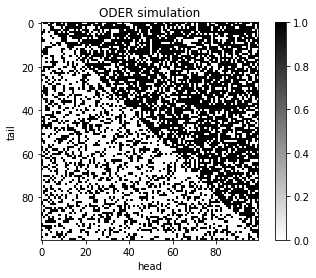

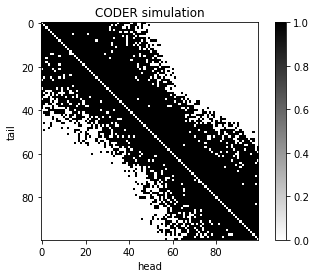

In [32]:
ODER_viz = edges_to_viz(ODER_test.edges,ODER_test.n)

plt.imshow(ODER_viz,cmap='binary')
plt.title('ODER simulation')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()

CODER_viz = edges_to_viz(CODER_test.edges,CODER_test.n)

plt.imshow(CODER_viz,cmap='binary')
plt.title('CODER simulation')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()